In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import time
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
import xgboost as xgb
from sklearn.utils import shuffle

In [2]:
df = pd.read_csv("/datasets/Churn.csv")
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


# Preprocessing

## Data Cleaning

Data Cleaning Strategy:

* Missing Values: `Tenure`
* Duplicates: To be checked
* Convert Data Types (Encoding): `GEography`, `Gender`
* Drop columns: `RowNumber`, `CustomerId`, `Surname`

### Duplicates

In [5]:
df.duplicated().sum()

0

In [6]:
df['CustomerId'].duplicated().sum()

0

The data doesn't have any duplicates

### Missing values

In [7]:
df['Tenure'].unique()

array([ 2.,  1.,  8.,  7.,  4.,  6.,  3., 10.,  5.,  9.,  0., nan])

In [8]:
df[df['Tenure'].isna()]

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,49,15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,52,15768193,Trevisani,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,61,15651280,Hunter,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9944,9945,15703923,Cameron,744,Germany,Male,41,NaN,190409.34,2,1,1,138361.48,0
9956,9957,15707861,Nucci,520,France,Female,46,NaN,85216.61,1,1,0,117369.52,1
9964,9965,15642785,Douglas,479,France,Male,34,NaN,117593.48,2,0,0,113308.29,0
9985,9986,15586914,Nepean,659,France,Male,36,NaN,123841.49,2,1,0,96833.00,0


<AxesSubplot:ylabel='Frequency'>

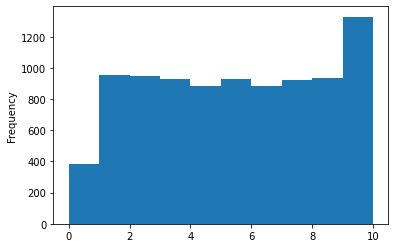

In [9]:
df['Tenure'].plot(kind='hist', bins=10)

The distribution of values of `Tenure` is even, I'll fill the missing values with random samples from the altinative values

In [10]:
df['Tenure'].fillna(random.choice(df['Tenure'].unique()), inplace=True)
df['Tenure'].isna().sum()

0

### Drop columns

In [11]:
df_cleaned = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
df_cleaned.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


## Preparing for training

### Label encoding

There are two categorical columns to be encoded, `Geograph` and `Gender`. Since this project is a classification, and I'll use some models based on the Tree structures, so I'll use the label encoding to deal with these two columns.

In [12]:
df_cleaned['Geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [13]:
columns_to_encode = ['Geography', 'Gender']
data_to_encode = df_cleaned[columns_to_encode].values
encoder = OrdinalEncoder()
encoded_data = encoder.fit_transform(data_to_encode)
df_cleaned[columns_to_encode] = encoded_data
df_cleaned.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0.0,0.0,42,2.0,0.00,1,1,1,101348.88,1
1,608,2.0,0.0,41,1.0,83807.86,1,0,1,112542.58,0
2,502,0.0,0.0,42,8.0,159660.80,3,1,0,113931.57,1
3,699,0.0,0.0,39,1.0,0.00,2,0,0,93826.63,0
4,850,2.0,0.0,43,2.0,125510.82,1,1,1,79084.10,0


In [14]:
df_cleaned['Geography'].unique()

array([0., 2., 1.])

### Balance of the classes

In [15]:
len(df_cleaned[df_cleaned['Exited'] == 1]), len(df_cleaned[df_cleaned['Exited'] == 0])

(2037, 7963)

The negative labels are 4 times more than the positive ones. The data is imbalanced.

### Split the dataset

In [16]:
X = df_cleaned.drop('Exited', axis=1)
y = df_cleaned['Exited']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Training

Before training, I'll define the function of calculating metrics

In [17]:
def calculate_acc(y_pred, y_test, model):
    score = round(metrics.accuracy_score(y_test, y_pred), 3)  #  ({(TN+TP)/(TN+TP+FN+FP)})
    fpr, tpr, _thresholds = metrics.roc_curve(y_test, y_pred)
    auc= round(metrics.auc(fpr, tpr), 3)
    con_matrix = confusion_matrix(y_test, y_pred)
    TN = con_matrix[0][0]
    FP = con_matrix[0][1]
    FN = con_matrix[1][0]
    TP = con_matrix[1][1]
    f1 = round(metrics.f1_score(y_test, y_pred, average='binary'), 3) # ({(2*TP)/(2*TP+FP+FN)})
    
    print(f"""
    The model is {model}:
    The accuracy is {score},
    The auc is {auc},
    The f1 score is {f1}.
    """)
    return score, auc, f1, con_matrix

## Train the model without taking into account the imbalance. 

I'll apply 5 popular classification models to train this dataset.

In [18]:
def train_pipeline(model_list, model_pipeline, X, y):
    time_consume = []
    acc_list = []
    auc_list = []
    cm_list = []
    f1_list = []
    best_threshold_list = []
    
    for model in model_pipeline:
        start = time.time()
        model.fit(X, y)
        y_pred = model.predict(X_val)
        y_pred_proba = model.predict_proba(X_val)[:, 1]  # 获取正类的概率值
        acc_list.append(metrics.accuracy_score(y_val, y_pred))
        fpr, tpr, thresholds = metrics.roc_curve(y_val, y_pred_proba)
        # best threshold by Youden Index 
#         J = tpr - fpr
#         idx = np.argmax(J)
#         best_threshold = thresholds[idx]
#         best_threshold_list.append(best_threshold)
        
        # best threshold by PR curve
        precision, recall, thresholds = precision_recall_curve(y_val, y_pred_proba)
        f1 = 2 * precision * recall / (precision + recall)
        idx = np.argmax(f1)
        best_threshold = thresholds[idx]
        best_threshold_list.append(best_threshold)
        
        auc_list.append(round(metrics.auc(fpr, tpr), 3))
        cm_list.append(confusion_matrix(y_val, y_pred))
        f1_list.append(round(metrics.f1_score(y_val, y_pred, average='binary'), 3))
        time_consume.append(round((time.time() - start), 3))
        
    result_df = pd.DataFrame({'Model': model_list, 'Accuracy': acc_list, 'AUC': auc_list, 'Best Threshold': best_threshold_list, 'F1 Score': f1_list, 'Time Consume (S)': time_consume})
    
    # Plot the confusion matrix
    fig = plt.figure(figsize=(20, 10))
    for i in range(len(cm_list)):
        cm = cm_list[i]
        model = model_list[i]
        sub = fig.add_subplot(2, 3, i+1).set_title(model)
        cm_plot = sns.heatmap(cm, annot=True, cmap="Blues_r", fmt='d')
        cm_plot.set_xlabel('Predicted Values')
        cm_plot.set_ylabel('Actual Values')
    return result_df

/tmp/ipykernel_178/1867808650.py:24: RuntimeWarning: invalid value encountered in true_divide
  f1 = 2 * precision * recall / (precision + recall)
/tmp/ipykernel_178/1867808650.py:24: RuntimeWarning: invalid value encountered in true_divide
  f1 = 2 * precision * recall / (precision + recall)


[15:45:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Model,Accuracy,AUC,Best Threshold,F1 Score,Time Consume (S)
0,Logistic Regression,0.804000,0.664,0.637921,0.125,0.177
1,Naive Bayes,0.796000,0.734,0.705959,0.105,0.092
2,Decision Tree,0.794667,0.683,1.000000,0.481,0.126
3,Random Forest,0.874000,0.849,0.380000,0.575,1.218
4,XGBoost,0.865333,0.853,0.378650,0.579,3.897


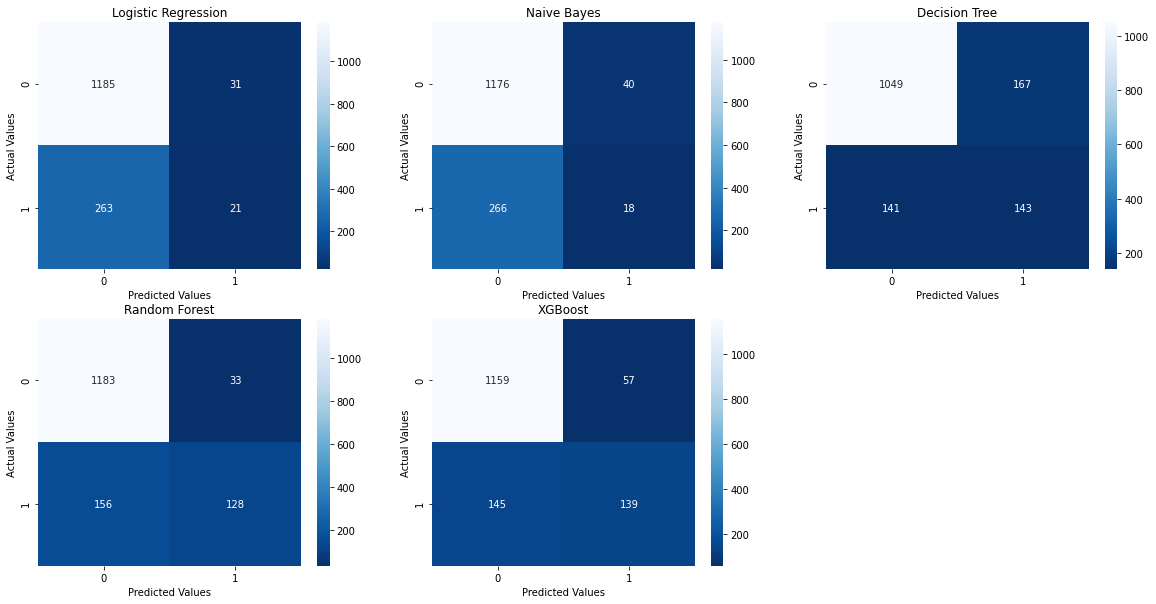

In [19]:
log_reg = LogisticRegression(random_state=42)
gnb = GaussianNB()
dtc_default = DecisionTreeClassifier(random_state=42)
rfc_default = RandomForestClassifier(random_state=42)
xgb_default = xgb.XGBClassifier(use_label_encoder=False, random_state=42)

model_list = ['Logistic Regression', 'Naive Bayes', 'Decision Tree', 'Random Forest', 'XGBoost']
model_pipeline = [log_reg, gnb, dtc_default, rfc_default, xgb_default]
result_df = train_pipeline(model_list, model_pipeline, X_train, y_train)
result_df

Implementing on the training set, the performance of these 5 models can be split into 3 groups. 
1. The Logistic Regression and Naive Bayes perform the worst. Although their accuracies are around 0.8, their f1 scores are less than 0.15. They predict too few TPs.
2. The Decision Tree is in the middle. It has the worst accuracy, but its f1 score is 0.454.
3. The best group models are the Random Forest and the XGBoost. For the accuracy, they achieve better than 0.85. For the f1 score, they are between 0.55 to 0.58.

I also recorded the best threshold of each model. The threshold of Decision Tree is 1 due to the default model only has 2 leaf nodes. I will figure it out if necessary later.

## Address the imbalanced dataset

I'll implement 2 methods to address the imbalanced dataset and optimize the model

### Method 1: Upsampling

I've printed that the negative label is about 4 times more than the positive labels. So I'll upsample 4 times of the positive class.

In [20]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    #print(features_zeros.shape, features_ones.shape, target_zeros.shape,target_ones.shape)
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=42
    )

    return features_upsampled, target_upsampled

In [21]:
X_upsampled, y_upsampled = upsample(
    X_train, y_train, 4
)

Run the default models training pipeline based on upsampled dataset

/tmp/ipykernel_178/1867808650.py:24: RuntimeWarning: invalid value encountered in true_divide
  f1 = 2 * precision * recall / (precision + recall)
/tmp/ipykernel_178/1867808650.py:24: RuntimeWarning: invalid value encountered in true_divide
  f1 = 2 * precision * recall / (precision + recall)


[15:45:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Model,Accuracy,AUC,Best Threshold,F1 Score,Time Consume (S)
0,Logistic Regression,0.483333,0.586,0.674698,0.346,0.151
1,Naive Bayes,0.688667,0.734,0.905935,0.454,0.091
2,Decision Tree,0.788667,0.677,1.000000,0.471,0.145
3,Random Forest,0.856000,0.846,0.420000,0.580,1.740
4,XGBoost,0.818667,0.833,0.608099,0.557,5.168


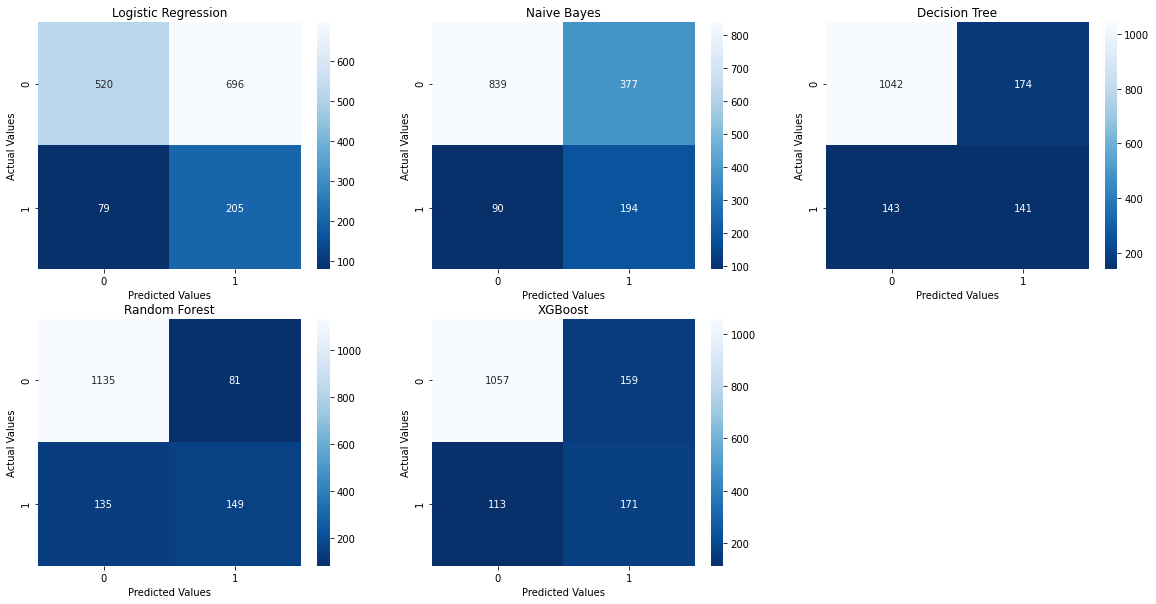

In [22]:
result_df = train_pipeline(model_list, model_pipeline, X_upsampled, y_upsampled)
result_df

After upsampling, accuracies of all models dropped except the Decision Tree. But the F1 scores of all models were better thanks to the increased number of positive labels.

The performance of Logistic Regression and Naive Bayes changed dramaticly. The accuracies dropped while the F1 score increased significantly.

Alike the changes of two models above, but the range of variation of Random Forest and XGBoot was slight. The f1 scores of Random Forest increased from 0.56 to 0.6. It looks upsampling works for the Random Forest rather than XGBoost.

Comparing AUC and F1 score, the AUC of Random Forest and XGBoost is 0.84, which means the model is good enough throughout different thresholds. The f1 scores are under 0.6, it shows there is optimization space in balancing precision and recall.

### Fine-tuning the hyperparameters

According to the model performance, I'll pick the Random Forest and XGBoost as the candidate models in the next steps, and use the random search method to find the best hyperparameters for models. 

#### Find best hyperparameters for Random Forest

It will take 3 ~ 4 minutes

In [ ]:
param_grid_rfc = {
    'n_estimators': [100, 200, 300, 400],  
    'max_depth': [None, 5, 10, 20],  
    'min_samples_split': [2, 3, 5, 8, 10, 15],  
    'min_samples_leaf': [1, 2, 4, 8],  
    'max_features': ['auto', 'sqrt'], 
    'bootstrap': [True, False]  
}
random_search_rfc = RandomizedSearchCV(estimator=rfc_default, param_distributions=param_grid_rfc, n_iter=10, cv=5)
random_search_rfc.fit(X_upsampled, y_upsampled)
print("Best parameters: ", random_search_rfc.best_params_)
print("Best score: ", random_search_rfc.best_score_)

In [ ]:
best_params = random_search_rfc.best_params_
rfc_opt = RandomForestClassifier(random_state=42, **best_params)
rfc_opt.fit(X_upsampled, y_upsampled)
y_pred = rfc_opt.predict(X_val)
cm = confusion_matrix(y_val, y_pred)
f1_score = round(metrics.f1_score(y_val, y_pred, average='binary'), 3)
print(cm, f1_score)

#### Find best hyperparameters for XGBoost

In [ ]:
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 8, 12, 16],
    'learning_rate': [0.1, 0.01],
    'num_parallel_tree': [1, 2, 4]
}

Note: It takes long time, I'll keep the results manually for later using

In [ ]:
#random_search_xgb = RandomizedSearchCV(xgb_default, param_distributions=param_grid_xgb, n_iter=10, scoring='accuracy')
#random_search_xgb.fit(X_upsampled, y_upsampled)
# print("Best parameters: ", random_search_xgb.best_params_)
# print("Best score: ", random_search_xgb.best_score_)

In [ ]:
# best_params_xgb = random_search_xgb.best_params_
best_params_xgb = {'num_parallel_tree': 2, 'n_estimators': 100, 'max_depth': 16, 'learning_rate': 0.1}
xgb_opt = xgb.XGBClassifier(random_state=42, **best_params_xgb)
xgb_opt.fit(X_upsampled, y_upsampled)
y_pred = xgb_opt.predict(X_val)
y_pred_proba = xgb_opt.predict_proba(X_val)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_proba)
cm = confusion_matrix(y_val, y_pred)
f1_score = round(metrics.f1_score(y_val, y_pred, average='binary'), 3)
# best threshold
f1 = 2 * precision * recall / (precision + recall)
idx = np.argmax(f1)
best_threshold = thresholds[idx]
print(cm, f1_score, best_threshold)

I applied the random search method to find the best parameters for these two models. For Random Forest, the result is worse than the default model, but for XGBoost, the optimized result is better.

### Method 2: Adjust threshold

For the binary classification task, if the dataset is imbalanced, we can get a better result by adjusting the threshold. 

During I training the model pipeline, I've calculated the best threshold by PR curve. In this step, I will choose the XGBoost as the training model because it has the highest F1 score and its best threshold is 0.61. Unlike the XGBoost, the best threshold of Random Forest is 0.51, which equals to the default value of a classifier, and it's no need to change.

In [24]:
rfc_default = RandomForestClassifier(random_state=42)
best_params_xgb = {'num_parallel_tree': 2, 'n_estimators': 100, 'max_depth': 16, 'learning_rate': 0.1}
xgb_opt = xgb.XGBClassifier(random_state=42, **best_params_xgb)
rfc_default.fit(X_upsampled, y_upsampled)
y_pred = rfc_default.predict(X_val)
y_pred_proba = rfc_default.predict_proba(X_val)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_proba)
cm = confusion_matrix(y_val, y_pred)
f1_score = round(metrics.f1_score(y_val, y_pred, average='binary'), 3)
# best threshold
f1 = 2 * precision * recall / (precision + recall)
idx = np.argmax(f1)
best_threshold = thresholds[idx]
print(cm, f1_score, best_threshold)

[[1135   81]
 [ 135  149]] 0.58 0.42


In [25]:
y_pred_opt = (y_pred_proba > best_threshold).astype(int)
cm_opt = confusion_matrix(y_val, y_pred_opt)
f1_opt = round(metrics.f1_score(y_val, y_pred_opt, average='binary'), 3)
print(f"""After adjusting the threshold to {best_threshold}, the confusion matrix is:
        {cm_opt}, 
        the F1 score is: {f1_opt}""")

After adjusting the threshold to 0.42, the confusion matrix is:
        [[1082  134]
 [ 110  174]], 
        the F1 score is: 0.588


## Testing

Now I'll use this model to test if the F1 score is greater than the requirement.

In [26]:
y_test_pred_proba = rfc_default.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_pred_proba > best_threshold).astype(int)
acc_test = metrics.accuracy_score(y_test, y_test_pred)
cm_test = confusion_matrix(y_test, y_test_pred)
f1_test = round(metrics.f1_score(y_test, y_test_pred, average='binary'), 3)
print(f"""The results on test set:
      The accuracy is: {acc_test}
      The confusion matrix is:
      {cm_test}, 
      The F1 score is: {f1_test}""")

The results on test set:
      The accuracy is: 0.8373333333333334
      The confusion matrix is:
      [[1064  136]
 [ 108  192]], 
      The F1 score is: 0.611


## Conclusion

In this project, I implement 3 steps: Preprocessing, Training and Testing.

* Preprocessing:
    * Data cleaning: 
        * Fill the missing values
        * Drop useless columns
    * Preparing for training
        * Label encoding categorical features.
        * Checking if the data is imbalanced. The negative labels are 4 time more than positive classes.
        * Split the data for training and testing.
* Training:
    * Train the models without taking into account the imbalance
        
        I applied 5 popular classification models to train the dataset. Due to the imbalance, the performance was bad. Although the accuracies of models were around 0.8, the best F1 score is 0.579.
        
        
    * Addressing the imbalanced dataset.
        * Method 1: Upsampling the positive classes.
        
        After upsampling, the performance was increased significantly.
        
        The best two models are XGBoost and Random Forest. I chose them to the next steps.
    